<a href="https://colab.research.google.com/github/tuanex/IANNWTF/blob/master/Homework5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib as plt
import numpy as np

In [2]:
# Loading the dataset
(training_dataset, testing_dataset), ds_info = tfds.load('cifar10', split=['train','test'], as_supervised=True, with_info=True)

In [3]:
# Prepare dataset
def prepare_dataset(cifar):# Flatten

    global batch_size

    # Reshape dataset
    #cifar = cifar.map(lambda img, target: (tf.reshape(img, (-1,3)), target))

    # Cast and redistribute values ato floats around 1
    cifar = cifar.map(lambda img, target: (tf.cast(img, tf.float32), target))
    cifar = cifar.map(lambda img, target: ((img / 255), target))

    # One-hottify target
    cifar = cifar.map(lambda img, target: (img, tf.one_hot(target, depth = 10)))

    # Load dataset into memory
    cifar = cifar.cache()

    # Shuffle dataset
    cifar = cifar.shuffle(1000)

    # Batch dataset
    cifar = cifar.batch(batch_size)

    # Prefetch dataset
    cifar = cifar.prefetch(20)

    return cifar

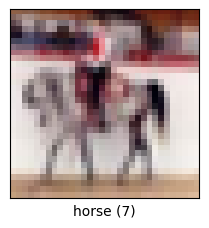

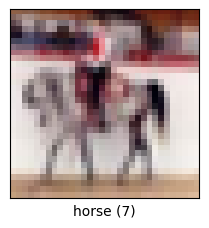

In [4]:
# Visualise sample
tfds.show_examples(training_dataset.take(1), ds_info, False)

In [5]:
class ConvNet(tf.keras.Model):

    global batch_size

    def __init__(self):

        super(ConvNet, self).__init__()

        # Layers
        self.conv_layer_1 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')
        self.conv_layer_2 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')
        self.pooling_1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.conv_layer_3 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')
        self.conv_layer_4 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')
        self.global_pool = tf.keras.layers.GlobalAvgPool2D()

        self.flatten = tf.keras.layers.Flatten()

        self.dense_1 = tf.keras.layers.Dense(batch_size * 32, activation = 'relu')
        self.dense_2 = tf.keras.layers.Dense(batch_size * 8, activation = 'relu')
        self.dense_3 = tf.keras.layers.Dense(64, activation = 'relu')

        self.out = tf.keras.layers.Dense(10, activation = 'softmax')


    # Apply model
    def call(self, x):

        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.pooling_1(x)

        x = self.conv_layer_3(x)
        x = self.conv_layer_4(x)
        x = self.global_pool(x)

        x = self.flatten(x)

        x = self.dense_1(x)
        x = self.dense_2(x)
        x = self.dense_3(x)

        x = self.out(x)
        return x

In [6]:
# Single step of training
# Taking as input one batch of training or testing data
def training_step(model, value, label, loss_func, optimizer):

    global loss_training
    global acc_training

    # Apply model on values and calculate loss based on prediction
    with tf.GradientTape() as tape:
        prediction = model.call(value)
        loss = loss_func(label, prediction)

    # Accuracy
    accuracy = np.argmax(label, axis=1) == np.argmax(prediction, axis=1)
    accuracy = np.mean(accuracy)

    # Logging accuracy and loss
    acc_training.append(accuracy)
    loss_training.append(loss)

    # Apply optimizer and change weights
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return model

def testing_step(model, value, label, loss_func):

    global loss_testing
    global acc_testing

    # Apply model on values and calculate loss based on prediction
    prediction = model.call(value)
    loss = loss_func(label, prediction)

    # Accuracy
    accuracy = np.argmax(label, axis = 1) == np.argmax(prediction, axis = 1)
    accuracy = np.mean(accuracy)

    # Logging accuracy and loss
    loss_testing.append(loss)
    acc_testing.append(accuracy)

def training(model, train_ds, test_ds, loss_func, optimizer, epochs = 15):

    global loss_training
    global loss_testing

    # Training
    for epoch in range(epochs):
        print(f"Starting epoch {epoch}")

        # Training
        # Iterating over batches
        for values, labels in train_ds:

            model = training_step(model, values, labels, loss_func, optimizer)

        print("Finished training, starting the testing of current model")

        # Testing
        # Iterating over batches
        for values, labels in test_ds:

            testing_step(model, values, labels, loss_func)

        print(f"Epoch finished with training loss of {loss_training[-1]}; and testing loss of {loss_testing[-1]}\n")

    return model

In [7]:
# Hyperparameters
batch_size = 15
learning_rate = 0.01
epochs = 10

# Variables
cnn_model = ConvNet()
loss_func = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate)

train_ds = training_dataset.apply(prepare_dataset)
test_ds = testing_dataset.apply(prepare_dataset)

# Loss and accuracies
loss_training = []
acc_training = []
loss_testing = []
acc_testing = []

#cnn.build()
#print(cnn_model.summary())

In [ ]:
tf.keras.backend.clear_session()
cnn_model = training(cnn_model, train_ds, test_ds, loss_func, optimizer, epochs)

In [ ]:
plt.pyplot.plot(acc_training)